In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

import tensorflow as tf

from PIL import Image
from PIL import ImageOps

In [2]:
model = tf.lite.Interpreter(model_path="model/model.tflite")
model.allocate_tensors()

In [3]:
input_details = model.get_input_details()
input_size = input_details[0]['shape'][2], input_details[0]['shape'][1]

In [4]:
def crop_image(image):
    cropped_image = None
    
    old_size = image.size
    desired_ratio = input_size[0] / input_size[1]
    old_ratio = old_size[0] / old_size[1]

    if old_ratio < desired_ratio:
        new_size = (old_size[0], int(old_size[0] / desired_ratio))
    else:
        new_size = (int(old_size[1] * desired_ratio), old_size[1])

    delta_w = new_size[0] - old_size[0]
    delta_h = new_size[1] - old_size[1]
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    cropped_image = ImageOps.expand(image, padding)
    
    return cropped_image

In [5]:
def preprocess_image(cropped_image):
    image_for_prediction = None
    
    resized_image = cropped_image.resize(input_size, Image.BILINEAR)
    
    image_for_prediction = np.asarray(resized_image).astype(np.float32)
    image_for_prediction = np.expand_dims(image_for_prediction, 0)
    image_for_prediction = image_for_prediction / 127.5 - 1
    
    return image_for_prediction

In [6]:
def segment_image(image_for_prediction, cropped_image):
    segmentation_map = None
    
    model.set_tensor(input_details[0]['index'], image_for_prediction)
    model.invoke()
    
    output_details = model.get_output_details()
    output_data = model.get_tensor(output_details[0]['index'])
    
    width, height = cropped_image.size
    
    segmentation_map = tf.argmax(tf.image.resize(output_data, (height, width)), axis=3)
    segmentation_map = tf.squeeze(segmentation_map).numpy().astype(np.int8)
    segmentation_map = np.where((segmentation_map == 11) | (segmentation_map == 13), segmentation_map, 0)
    segmentation_map = np.where(segmentation_map == 11, 1, segmentation_map)
    segmentation_map = np.where(segmentation_map == 13, 2, segmentation_map)
    
    return segmentation_map

In [7]:
def create_cityscapes_label_colormap():
  colormap = np.zeros((256, 3), dtype=np.uint8)
  colormap[0] = [128, 128, 128]
  colormap[1] = [220, 20, 60]
  colormap[2] = [0, 0, 142]

  return colormap

In [8]:
def label_to_color_image(label):
  colormap = create_cityscapes_label_colormap()

  return colormap[label]

In [ ]:
def visualize(image, segmentation_map):
  plt.figure(figsize=(15, 5))

  plt.subplot(1, 3, 1)
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(1, 3, 2)
  seg_image = label_to_color_image(segmentation_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(1, 3, 3)
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.5)
  plt.axis('off')
  plt.title('segmentation overlay')

  plt.grid('off')
  plt.show()

In [10]:
images_path = "data/"
images = [Image.open(images_path + image_name) for image_name in os.listdir(images_path)]

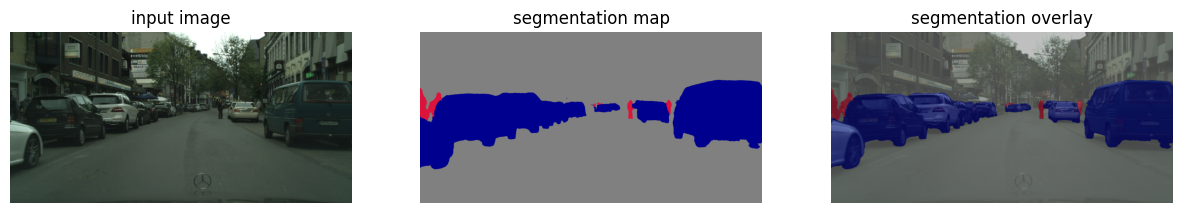

In [ ]:
for image in images:
    cropped_image = crop_image(image)
    image_for_prediction = preprocess_image(cropped_image)
    segmentation_map = segment_image(image_for_prediction, cropped_image)
    
    visualize(cropped_image, segmentation_map)